Evaluating on clean dataset (Task 1)


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 10.63it/s]


Clean Top-1: 76.00%, Top-5: 94.20%
Running FGSM attack (Task 2)


Generating FGSM: 100%|██████████| 8/8 [00:01<00:00,  5.07it/s]


Max L∞ distance: 0.02000 (ε was 0.02)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.000005].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.000005].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.000005].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.000005].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.000005].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.85624456..1.000005].


Saved FGSM dataset to: ./AdversarialTestSets/adv_test_set1.pt
Saved FGSM visualization to: FGSM_Visualizations/fgsm_visualization.png


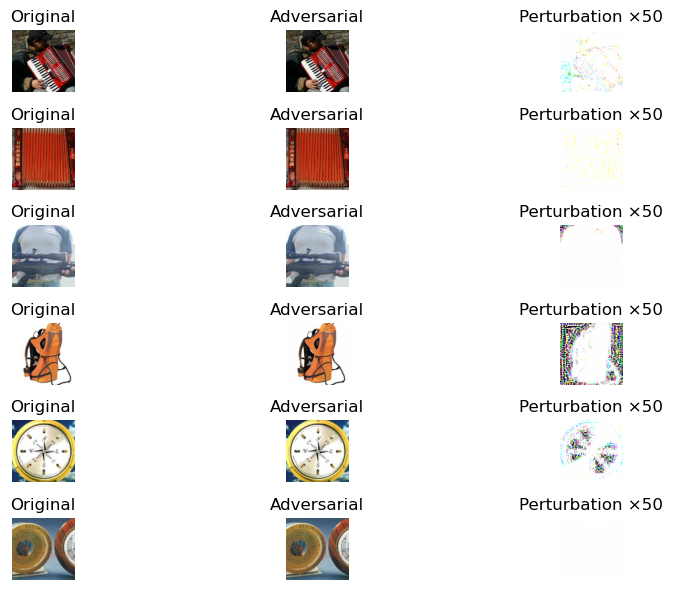

Evaluating FGSM adversarial set


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 19.30it/s]

FGSM Top-1: 6.20%, Top-5: 35.40%


In [3]:
import os
import json
import ast
import requests
import torch
import torch.nn.functional as F
from torchvision import models, datasets, transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm import tqdm

# Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATASET_PATH = "./test_dataset"
LABELS_JSON = os.path.join(DATASET_PATH, "labels_list.json")
FGSM_EPSILON = 0.02
BATCH_SIZE = 64

mean_vals = torch.tensor([0.485, 0.456, 0.406])[:, None, None].to(device)
std_vals = torch.tensor([0.229, 0.224, 0.225])[:, None, None].to(device)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Step 1: Load labels_list.json and map index → WNID
with open(LABELS_JSON, "r") as f:
    entries = json.load(f)

index_to_label = {int(e.split(":")[0]): e.split(":")[1].strip() for e in entries}
subset_indices = set(index_to_label.keys())

URL = "https://gist.githubusercontent.com/fnielsen/4a5c94eaa6dcdf29b7a62d886f540372/raw/imagenet_label_to_wordnet_synset.txt"
synset_text = requests.get(URL).text
synset_map = ast.literal_eval(synset_text)

idx_to_wnid = {}
for idx_str, data in synset_map.items():
    idx = int(idx_str)
    if idx in subset_indices:
        wnid = "n" + data["id"].split("-")[0]
        idx_to_wnid[idx] = wnid

wnid_to_global = {wnid: idx for idx, wnid in idx_to_wnid.items()}
valid_wnids = set(wnid_to_global.keys())

# Step 2: Dataset loader and mapping
class FilteredImageFolder(datasets.ImageFolder):
    def find_classes(self, directory):
        dirs = [
            d for d in os.listdir(directory)
            if os.path.isdir(os.path.join(directory, d)) and d in valid_wnids
        ]
        if not dirs:
            raise ValueError("No valid WNID folders found. Check folder names or JSON.")
        dirs.sort()
        class_to_idx = {cls_name: i for i, cls_name in enumerate(dirs)}
        return dirs, class_to_idx

base_ds = FilteredImageFolder(DATASET_PATH, transform=transform)

folder_to_global = {
    idx: wnid_to_global[wnid]
    for idx, wnid in enumerate(base_ds.classes)
}

class SubsetDataset(Dataset):
    def __init__(self, base_ds, f2g):
        self.base = base_ds
        self.map = f2g
    def __len__(self):
        return len(self.base)
    def __getitem__(self, idx):
        img, folder_idx = self.base[idx]
        return img, self.map[folder_idx]

ds = SubsetDataset(base_ds, folder_to_global)
loader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# Step 3: Load pretrained ResNet-34
model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
model = model.to(device).eval()

# Step 4: Evaluation function
@torch.no_grad()
def evaluate_model(model, dataloader, topk=(1, 5)):
    total, correct = {k: 0 for k in topk}, {k: 0 for k in topk}
    for x, y in tqdm(dataloader, desc="Evaluating"):
        x, y = x.to(device), y.to(device)
        logits = model(x)
        _, preds = logits.topk(max(topk), dim=1)
        for k in topk:
            match = (preds[:, :k] == y.unsqueeze(1)).any(dim=1)
            correct[k] += match.sum().item()
            total[k] += y.size(0)
    return {k: correct[k] / total[k] for k in topk}

# Step 5: FGSM attack
def generate_fgsm_adversaries(inputs, labels, model, epsilon):
    inputs = inputs.clone().detach().to(device).requires_grad_(True)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = F.cross_entropy(outputs, labels)
    loss.backward()
    adv_inputs = inputs + epsilon * inputs.grad.sign()
    clip_min = (0.0 - mean_vals) / std_vals
    clip_max = (1.0 - mean_vals) / std_vals
    adv_inputs = torch.max(torch.min(adv_inputs, clip_max), clip_min)
    return adv_inputs.detach()

# Step 6: Visualization and save
def visualize_and_save_triplets(triplets, save_path="FGSM_Visualizations/fgsm_visualization.png"):
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    def denorm(img): return (img * std_vals.cpu()) + mean_vals.cpu()

    fig, axes = plt.subplots(len(triplets), 3, figsize=(10, 6))
    for idx, (orig, adv, delta) in enumerate(triplets):
        axes[idx, 0].imshow(denorm(orig).permute(1, 2, 0).clip(0, 1))
        axes[idx, 0].set_title("Original")
        axes[idx, 1].imshow(denorm(adv).permute(1, 2, 0).clip(0, 1))
        axes[idx, 1].set_title("Adversarial")
        axes[idx, 2].imshow(delta.permute(1, 2, 0).abs().clip(0, 0.05) * 50)
        axes[idx, 2].set_title("Perturbation ×50")
        for ax in axes[idx]: ax.axis('off')

    plt.tight_layout()
    plt.savefig(save_path)
    print(f"Saved FGSM visualization to: {save_path}")
    plt.show()

# Step 7: Generate FGSM dataset
def create_fgsm_dataset(model, clean_loader, epsilon, save_path):
    adv_examples, adv_targets = [], []
    vis_triplets = []
    orig_examples = []

    for imgs, labels in tqdm(clean_loader, desc="Generating FGSM"):
        orig_examples.append(imgs.clone().cpu())
        imgs = imgs.to(device)
        adv_imgs = generate_fgsm_adversaries(imgs, labels, model, epsilon)
        adv_examples.append(adv_imgs.cpu())
        adv_targets.append(labels)

        if len(vis_triplets) < 5:
            for i in range(min(2, imgs.size(0))):
                orig_img_cpu = imgs[i].detach().cpu()
                adv_img_cpu = adv_imgs[i].detach().cpu()
                delta = adv_img_cpu - orig_img_cpu
                vis_triplets.append((orig_img_cpu, adv_img_cpu, delta))

    adv_imgs_tensor = torch.cat(adv_examples)
    adv_lbls_tensor = torch.cat(adv_targets)
    orig_tensor = torch.cat(orig_examples)

    linf = (adv_imgs_tensor - orig_tensor).abs().max().item()
    print(f"Max L∞ distance: {linf:.5f} (ε was {epsilon})")

    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    torch.save({'images': adv_imgs_tensor, 'labels': adv_lbls_tensor}, save_path)
    print(f"Saved FGSM dataset to: {save_path}")

    visualize_and_save_triplets(vis_triplets)

    return DataLoader(TensorDataset(adv_imgs_tensor, adv_lbls_tensor), batch_size=BATCH_SIZE)

# Step 8: Task 1 – Baseline Evaluation
print("Evaluating on clean dataset (Task 1)")
clean_acc = evaluate_model(model, loader)
print(f"Clean Top-1: {clean_acc[1]*100:.2f}%, Top-5: {clean_acc[5]*100:.2f}%")

# Step 9: Task 2 – FGSM Attack
print("Running FGSM attack (Task 2)")
fgsm_loader = create_fgsm_dataset(
    model=model,
    clean_loader=loader,
    epsilon=FGSM_EPSILON,
    save_path="./AdversarialTestSets/adv_test_set1.pt"
)

print("Evaluating FGSM adversarial set")
fgsm_acc = evaluate_model(model, fgsm_loader)
print(f"FGSM Top-1: {fgsm_acc[1]*100:.2f}%, Top-5: {fgsm_acc[5]*100:.2f}%")
